# Data Preprocessing

Analyse und Aufbereitung des **UCI Hydraulic Systems** Dataset: https://archive.ics.uci.edu/dataset/447/condition+monitoring+of+hydraulic+systems

## Übersicht der Analyseschritte

1. **Datensatz beschreiben** - Zielvariablen und Struktur verstehen
2. **Aggregation der Daten** - Time-Series Features extrahieren
3. **Missing Values prüfen** - Vollständigkeit sicherstellen
4. **Plausibilitätsprüfung** - Min/Max, Mean/Median validieren
5. **Korrelationen** - Zusammenhänge zwischen Features analysieren

## 1. Import der benötigten Bibliotheken

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Konfiguration für bessere Plots
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style("whitegrid")
sns.set_palette("husl")

# Pfade definieren
DATA_DIR = Path('../data')
DOCS_DIR = Path('../docs')
OUT_DIR = Path('../out')

print("✓ Bibliotheken erfolgreich importiert")

✓ Bibliotheken erfolgreich importiert


## 2. Zum Datensatz

Der **UCI Hydraulic Systems Dataset** enthält 2.205 Messzyklen (je 60s) von einem hydraulischen Prüfstand. 
Der Prüfstand besteht u.A. aus Kühlung und Filter, am gesamten Prüfstand nehmen Sensoren 
1. **Druck** 
2. **Durchfluss**
3. **Temperatur**

der vier Komponenten (Kühler, Ventil, Pumpe, Akkumulator) auf. Insgesamt wurden 2205 Zyklen mit 17 Attributen aufgenommen

### Zielvariablen

Das System überwacht 5 Zielgrößen, die in `docs/profile.txt` gespeichert sind:

1. **Cooler Condition** - Zustand des Kühlers (3, 20, 100)
2. **Valve Condition** - Zustand des Ventils (73, 80, 90, 100)
3. **Pump Leakage** - Pumpenleckage (0, 1, 2)
4. **Accumulator Pressure** - Akkumulatordruck (90, 100, 115, 130)
5. **Stable Flag** - Systemstabilität (0 = stabil, 1 = instabil)

### Anwendung / Kontext

Mit einer Regression könnte man hier in Richtung Predictive Maintenance gehen.

In [14]:
# Datenstruktur der Rohdaten anzeigen
print("=" * 70)
print("STRUKTUR DER ROHDATEN (ZEITREIHEN)")
print("=" * 70)
print(f"Anzahl Messzyklen: 2.205")
print(f"Anzahl logischer Sensoren: 17")
print(f"  - 6 Drucksensoren (PS1-PS6)")
print(f"  - 1 Elektr. Leistungsaufnahme (EPS1)")
print(f"  - 2 Volumenstromsensoren (FS1-FS2)")
print(f"  - 4 Temperatursensoren (TS1-TS4)")
print(f"  - 1 Vibrationssensor (VS1)")
print(f"  - 1 Kühleffizienz (CE)")
print(f"  - 1 Kühlleistung (CP)")
print(f"  - 1 Effizienzfaktor (SE)")
print(f"\nZeitpunkte pro Sensor: bis zu 6.000 (je nach Samplingrate 1-100 Hz)")
print(f"Gesamtanzahl Spalten in Rohdaten: 43.680")
print(f"  (17 Sensoren × durchschnittlich ~2.570 Zeitpunkte)")
print("\n→ Die Rohdaten sind NICHT Teil dieses Notebooks.")
print("→ Wir arbeiten mit den bereits AGGREGIERTEN Features.")

STRUKTUR DER ROHDATEN (ZEITREIHEN)
Anzahl Messzyklen: 2.205
Anzahl logischer Sensoren: 17
  - 6 Drucksensoren (PS1-PS6)
  - 1 Elektr. Leistungsaufnahme (EPS1)
  - 2 Volumenstromsensoren (FS1-FS2)
  - 4 Temperatursensoren (TS1-TS4)
  - 1 Vibrationssensor (VS1)
  - 1 Kühleffizienz (CE)
  - 1 Kühlleistung (CP)
  - 1 Effizienzfaktor (SE)

Zeitpunkte pro Sensor: bis zu 6.000 (je nach Samplingrate 1-100 Hz)
Gesamtanzahl Spalten in Rohdaten: 43.680
  (17 Sensoren × durchschnittlich ~2.570 Zeitpunkte)

→ Die Rohdaten sind NICHT Teil dieses Notebooks.
→ Wir arbeiten mit den bereits AGGREGIERTEN Features.


In [3]:
# Zielvariablen laden
targets = pd.read_csv(DOCS_DIR / 'profile.txt', sep='\t')

print(f"Shape der Zielvariablen: {targets.shape}")
print(f"\nSpalten: {list(targets.columns)}\n")

# Übersicht der Zielvariablen
print("=" * 70)
print("ÜBERSICHT DER ZIELVARIABLEN")
print("=" * 70)
display(targets.head(10))

# Statistiken für jede Zielvariable
print("\n" + "=" * 70)
print("VERTEILUNG DER ZIELVARIABLEN")
print("=" * 70)
for col in targets.columns:
    print(f"\n{col}:")
    print(targets[col].value_counts().sort_index())

Shape der Zielvariablen: (2204, 5)

Spalten: ['3', '100', '0', '130', '1']

ÜBERSICHT DER ZIELVARIABLEN


,3,100,0,130,1
0,3,100,0,130,1
1,3,100,0,130,1
2,3,100,0,130,1
3,3,100,0,130,1
4,3,100,0,130,1
5,3,100,0,130,1
6,3,100,0,130,1
7,3,100,0,130,1
8,3,100,0,130,1
9,3,100,0,130,1



VERTEILUNG DER ZIELVARIABLEN

3:
3
3      731
20     732
100    741
Name: count, dtype: int64

100:
100
73      360
80      360
90      360
100    1124
Name: count, dtype: int64

0:
0
0    1220
1     492
2     492
Name: count, dtype: int64

130:
130
90     808
100    399
115    399
130    598
Name: count, dtype: int64

1:
1
0    1449
1     755
Name: count, dtype: int64


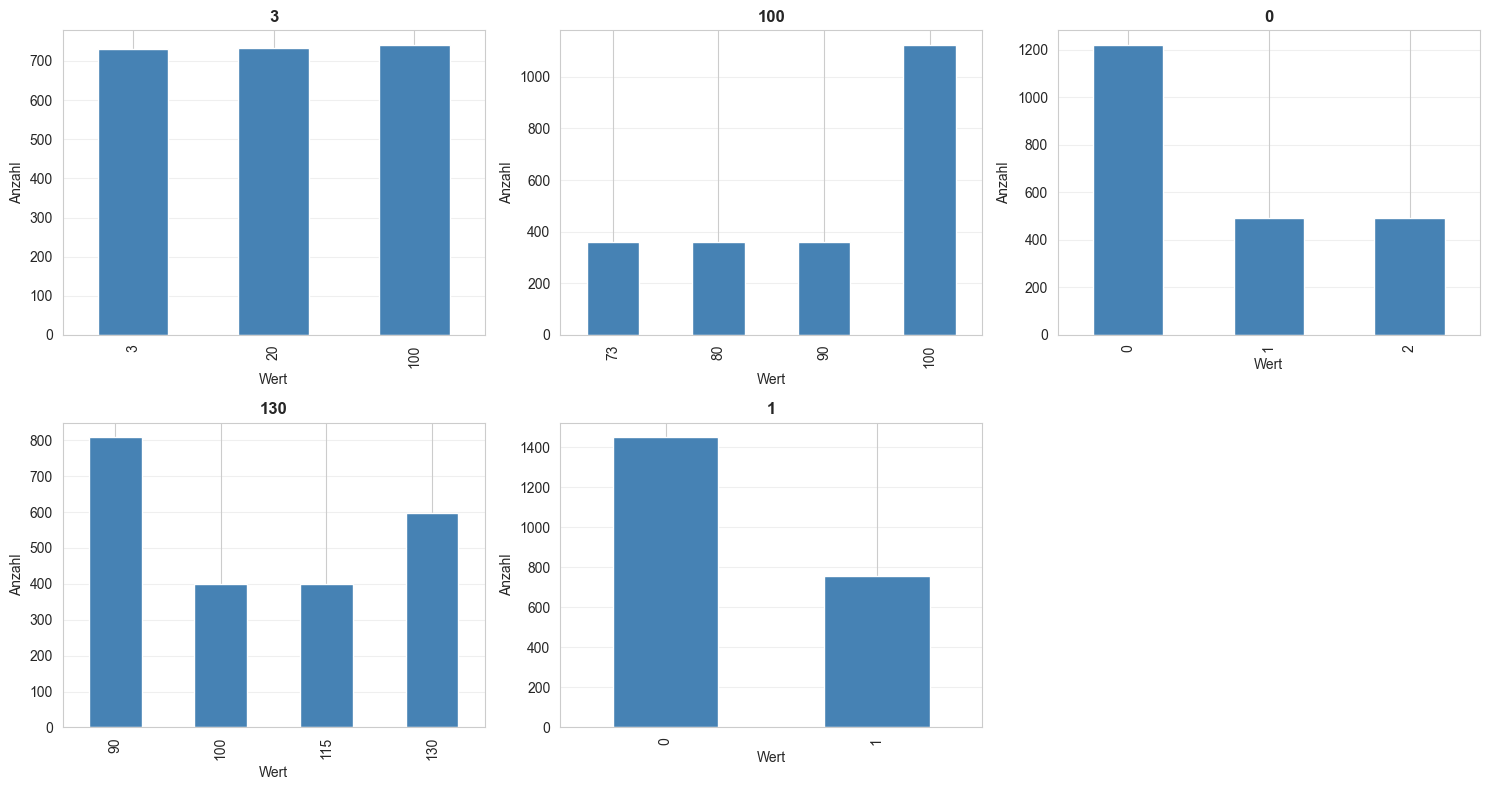

In [ ]:
# Visualisierung der Zielvariablen
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

# Bessere Namen für die Plots
target_labels = {
    'cooler_condition': 'Kühlerzustand',
    'valve_condition': 'Ventilzustand',
    'pump_leakage': 'Pumpenleckage',
    'accumulator_pressure': 'Akkumulatordruck',
    'stable_flag': 'Systemstabilität'
}

for idx, col in enumerate(targets.columns):
    targets[col].value_counts().sort_index().plot(
        kind='bar', ax=axes[idx], color='steelblue'
    )
    # Titel mit deutscher Bezeichnung UND technischem Namen
    axes[idx].set_title(f'{target_labels.get(col, col)}\n({col})', 
                        fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Wert')
    axes[idx].set_ylabel('Anzahl Messzyklen')
    axes[idx].grid(axis='y', alpha=0.3)

# Letzte Subplot leer lassen
axes[-1].axis('off')

plt.suptitle('Verteilung der Zielvariablen', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 3. Aggregation / Feature Engineering

Die Rohdaten liegen als Zeitreihe vor:
- **17 Sensoren** mit unterschiedlichen Samplingraten (1 Hz bis 100 Hz)
- **2.205 Messzyklen** (Zeilen)
- **Bis zu 6.000 Zeitpunkte** pro Sensor (Spalten)
- **43.680 Spalten** in den Rohdaten

### Aggregationsprozess

Für jeden Sensor werden acht Features berechnet:
- `mean` - Durchschnitt
- `std` - Standardabweichung
- `min` - Minimum
- `max` - Maximum
- `median` - Median
- `q25` - 25% Quantil
- `q75` - 75% Quantil
- `range` - Spannweite (max - min)

**Resultat:** 17 Sensoren × 8 Features = 136 aggregierte Features
(anstatt 43.680 Spalten)

In [5]:
# Aggregierte Features laden (aus prep_corrected.py generiert)
# Falls noch nicht vorhanden, führe zuerst prep_corrected.py aus

if (OUT_DIR / 'features_complete.csv').exists():
    df = pd.read_csv(OUT_DIR / 'features_complete.csv')
    print(f"✓ Aggregierte Features erfolgreich geladen")
    print(f"\nShape: {df.shape}")
    print(f"Spalten: {df.shape[1]} (136 Features + 5 Zielvariablen)")
    print(f"Zeilen: {df.shape[0]} Messzyklen\n")
    
    # Feature-Gruppen nach Sensor
    sensor_names = [
        'ps1', 'ps2', 'ps3', 'ps4', 'ps5', 'ps6',
        'eps1', 'fs1', 'fs2', 'ts1', 'ts2', 'ts3', 'ts4',
        'vs1', 'ce', 'cp', 'se'
    ]
    
    print("=" * 70)
    print("SENSOREN IM DATASET")
    print("=" * 70)
    for sensor in sensor_names:
        sensor_cols = [col for col in df.columns if col.startswith(f'{sensor}_')]
        if sensor_cols:
            print(f"{sensor:5s} → {len(sensor_cols):2d} Features: {', '.join([c.split('_')[1] for c in sensor_cols])}")
    
    # Erste Zeilen anzeigen
    print("\n" + "=" * 70)
    print("ERSTE ZEILEN DES AGGREGIERTEN DATASETS")
    print("=" * 70)
    display(df.head())
else:
    print("❌ Datei nicht gefunden!")
    print("Führe zuerst 'python prep_corrected.py' aus, um die Features zu generieren.")

✓ Aggregierte Features erfolgreich geladen

Shape: (2205, 141)
Spalten: 141 (136 Features + 5 Zielvariablen)
Zeilen: 2205 Messzyklen

SENSOREN IM DATASET
ps1   →  8 Features: mean, std, min, max, median, q25, q75, range
ps2   →  8 Features: mean, std, min, max, median, q25, q75, range
ps3   →  8 Features: mean, std, min, max, median, q25, q75, range
ps4   →  8 Features: mean, std, min, max, median, q25, q75, range
ps5   →  8 Features: mean, std, min, max, median, q25, q75, range
ps6   →  8 Features: mean, std, min, max, median, q25, q75, range
eps1  →  8 Features: mean, std, min, max, median, q25, q75, range
fs1   →  8 Features: mean, std, min, max, median, q25, q75, range
fs2   →  8 Features: mean, std, min, max, median, q25, q75, range
ts1   →  8 Features: mean, std, min, max, median, q25, q75, range
ts2   →  8 Features: mean, std, min, max, median, q25, q75, range
ts3   →  8 Features: mean, std, min, max, median, q25, q75, range
ts4   →  8 Features: mean, std, min, max, median, q25,

,ce_mean,ce_std,ce_min,ce_max,ce_median,ce_q25,ce_q75,ce_range,cp_mean,cp_std,...,vs1_max,vs1_median,vs1_q25,vs1_q75,vs1_range,cooler_condition,valve_condition,pump_leakage,accumulator_pressure,stable_flag
0,39.601350,6.370535,28.866,47.438,40.6755,33.61075,45.93825,18.572,1.862750,0.279385,...,0.624,0.5770,0.55300,0.60300,0.092,3,100,0,130,1
1,25.786433,1.686129,23.320,29.208,25.3855,24.40025,27.24150,5.888,1.255550,0.074605,...,0.626,0.5595,0.54700,0.57850,0.102,3,100,0,130,1
2,22.218233,0.638345,21.220,23.554,22.1040,21.64050,22.74900,2.334,1.113217,0.023263,...,0.662,0.5620,0.54925,0.59525,0.133,3,100,0,130,1
3,20.459817,0.455755,19.673,21.565,20.4805,20.13825,20.71025,1.892,1.062150,0.024621,...,0.645,0.5550,0.54775,0.59200,0.118,3,100,0,130,1
4,19.787017,0.290156,19.133,20.460,19.7985,19.63250,19.96675,1.327,1.070467,0.021477,...,0.660,0.5760,0.54850,0.59275,0.136,3,100,0,130,1


## 4. Missing Values

Laut Doku sollte der Datensatz keine fehlenden Werte enthalten.

Dennoch kurze Absicherung:

In [6]:
if 'df' in locals():
    # Anzahl fehlender Werte pro Spalte
    missing_counts = df.isnull().sum()
    missing_total = missing_counts.sum()
    
    print("=" * 70)
    print("MISSING VALUES ANALYSE")
    print("=" * 70)
    print(f"Gesamtanzahl fehlender Werte: {missing_total}")
    print(f"Prozentsatz: {(missing_total / (df.shape[0] * df.shape[1]) * 100):.2f}%")
    
    if missing_total > 0:
        print("\nSpalten mit fehlenden Werten:")
        print(missing_counts[missing_counts > 0].sort_values(ascending=False))
    else:
        print("\n✓ KEINE FEHLENDEN WERTE GEFUNDEN!")
        print("Der Datensatz ist vollständig.")
    
    # Visualisierung (falls fehlende Werte existieren)
    if missing_total > 0:
        plt.figure(figsize=(12, 6))
        missing_counts[missing_counts > 0].sort_values(ascending=False).plot(kind='bar')
        plt.title('Missing Values pro Spalte', fontsize=14, fontweight='bold')
        plt.xlabel('Spalte')
        plt.ylabel('Anzahl fehlender Werte')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
else:
    print("❌ Dataset nicht geladen. Führe zuerst die vorherigen Zellen aus.")

MISSING VALUES ANALYSE
Gesamtanzahl fehlender Werte: 0
Prozentsatz: 0.00%

✓ KEINE FEHLENDEN WERTE GEFUNDEN!
Der Datensatz ist vollständig.


## 5. Plausibilitätsprüfung der Attribute

Wir prüfen die statistischen Kennzahlen jedes Features, um Ausreißer oder Probleme zu identifizieren:

- **Min/Max:** Wertebereich plausibel?
- **Mean vs. Median:** Hinweise auf Schiefe (Skewness)?
- **Stbw:** Variabilität der Daten

In [7]:
if 'df' in locals():
    # Nur numerische Features (ohne Zielvariablen)
    feature_cols = [col for col in df.columns if '_' in col and col not in targets.columns]
    features_only = df[feature_cols]
    
    # Deskriptive Statistiken
    stats = features_only.describe().T
    
    print("=" * 70)
    print("DESKRIPTIVE STATISTIKEN DER FEATURES")
    print("=" * 70)
    print(f"Anzahl Features: {len(feature_cols)}\n")
    
    # Erste 20 Features anzeigen
    display(stats.head(20))
    
    print("\n" + "=" * 70)
    print("PLAUSIBILITÄTSPRÜFUNG")
    print("=" * 70)
    
    # Features mit negativen Werten (falls nicht erwartet)
    negative_mins = stats[stats['min'] < 0]
    if len(negative_mins) > 0:
        print(f"\n⚠ Features mit negativen Werten: {len(negative_mins)}")
        print(negative_mins[['min', 'max', 'mean']].head(10))
    else:
        print("\n✓ Keine negativen Werte gefunden")
    
    # Features mit sehr hoher Standardabweichung (möglicherweise Ausreißer)
    high_std = stats[stats['std'] > stats['mean']].sort_values('std', ascending=False)
    if len(high_std) > 0:
        print(f"\n⚠ Features mit STD > MEAN (hohe Variabilität): {len(high_std)}")
        print(high_std[['mean', 'std', 'min', 'max']].head(10))
    
    # Features mit konstanten/sehr geringen Werten
    low_std = stats[stats['std'] < 0.01].sort_values('std')
    if len(low_std) > 0:
        print(f"\n⚠ Features mit sehr geringer Variabilität (STD < 0.01): {len(low_std)}")
        print(low_std[['mean', 'std', 'min', 'max']].head(10))
    else:
        print("\n✓ Alle Features haben ausreichende Variabilität")
        
else:
    print("❌ Dataset nicht geladen.")

DESKRIPTIVE STATISTIKEN DER FEATURES
Anzahl Features: 141



,count,mean,std,min,25%,50%,75%,max
ce_mean,2205.0,31.299077,11.575330,17.555983,20.084650,27.392533,46.677383,47.903667
ce_std,2205.0,0.287325,0.199760,0.063164,0.217363,0.264125,0.329684,6.370535
ce_min,2205.0,30.785665,11.583481,17.042000,19.513000,26.862000,46.168000,47.626000
ce_max,2205.0,31.880312,11.602740,18.142000,20.694000,27.983000,47.272000,48.777000
ce_median,2205.0,31.287446,11.570829,17.501000,20.083000,27.363500,46.648500,47.945000
ce_q25,2205.0,31.078011,11.574876,17.362000,19.875750,27.151250,46.474750,47.772750
ce_q75,2205.0,31.506510,11.574789,17.746000,20.345000,27.592000,46.856250,48.129000
ce_range,2205.0,1.094648,0.585637,0.375000,0.871000,1.048000,1.241000,18.572000
cp_mean,2205.0,1.808399,0.278263,1.062150,1.550100,1.739683,2.148483,2.840100
cp_std,2205.0,0.022692,0.011138,0.006914,0.018377,0.021472,0.025096,0.343522



PLAUSIBILITÄTSPRÜFUNG

✓ Keine negativen Werte gefunden

⚠ Features mit STD > MEAN (hohe Variabilität): 13
                       mean        std  min         max
cooler_condition  41.240816  42.383143  3.0  100.000000
ps4_max            3.172446   4.349040  0.0   10.266000
ps4_q75            2.636674   4.302525  0.0   10.226000
ps4_median         2.572349   4.295579  0.0   10.207000
ps4_q25            2.536717   4.290085  0.0   10.190000
ps4_mean           2.600266   4.279355  0.0   10.207068
ps4_min            2.475427   4.257247  0.0   10.133000
ps4_range          0.697019   1.733458  0.0   10.238000
pump_leakage       0.669388   0.817233  0.0    2.000000
stable_flag        0.342857   0.474772  0.0    1.000000

⚠ Features mit sehr geringer Variabilität (STD < 0.01): 7
                 mean       std       min       max
ps3_min  0.000000e+00  0.000000  0.000000  0.000000
ps2_min  0.000000e+00  0.000000  0.000000  0.000000
se_min   0.000000e+00  0.000000  0.000000  0.000000
fs1_min  

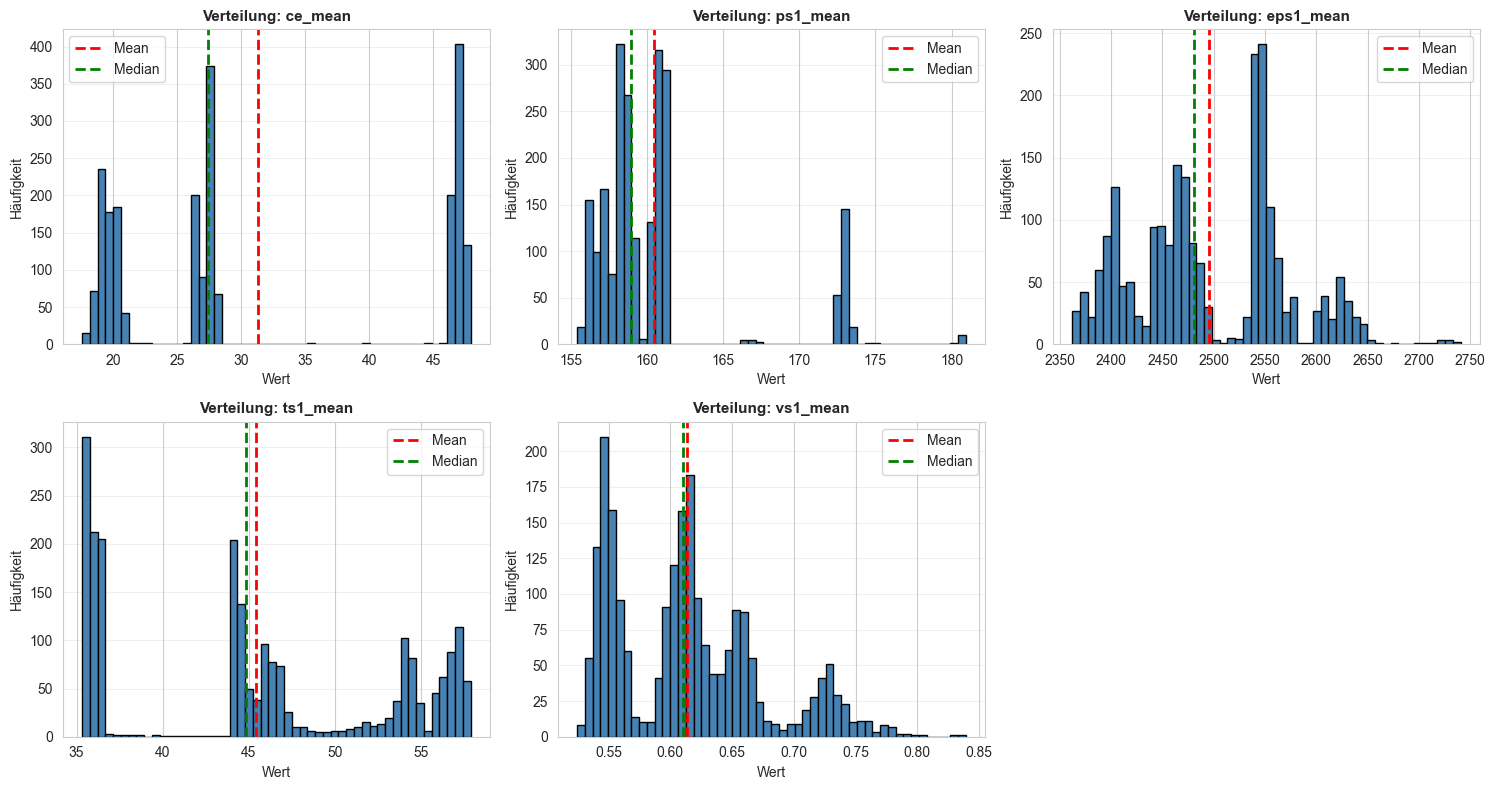

In [8]:
if 'df' in locals():
    # Verteilung einiger wichtiger Features visualisieren
    important_features = ['ce_mean', 'ps1_mean', 'eps1_mean', 'ts1_mean', 'vs1_mean']
    available_features = [f for f in important_features if f in df.columns]
    
    if len(available_features) > 0:
        fig, axes = plt.subplots(2, 3, figsize=(15, 8))
        axes = axes.flatten()
        
        for idx, feature in enumerate(available_features):
            df[feature].hist(bins=50, ax=axes[idx], color='steelblue', edgecolor='black')
            axes[idx].set_title(f'Verteilung: {feature}', fontsize=11, fontweight='bold')
            axes[idx].set_xlabel('Wert')
            axes[idx].set_ylabel('Häufigkeit')
            axes[idx].axvline(df[feature].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
            axes[idx].axvline(df[feature].median(), color='green', linestyle='--', linewidth=2, label='Median')
            axes[idx].legend()
            axes[idx].grid(axis='y', alpha=0.3)
        
        # Nicht verwendete Subplots ausblenden
        for idx in range(len(available_features), len(axes)):
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.show()
else:
    print("❌ Dataset nicht geladen.")

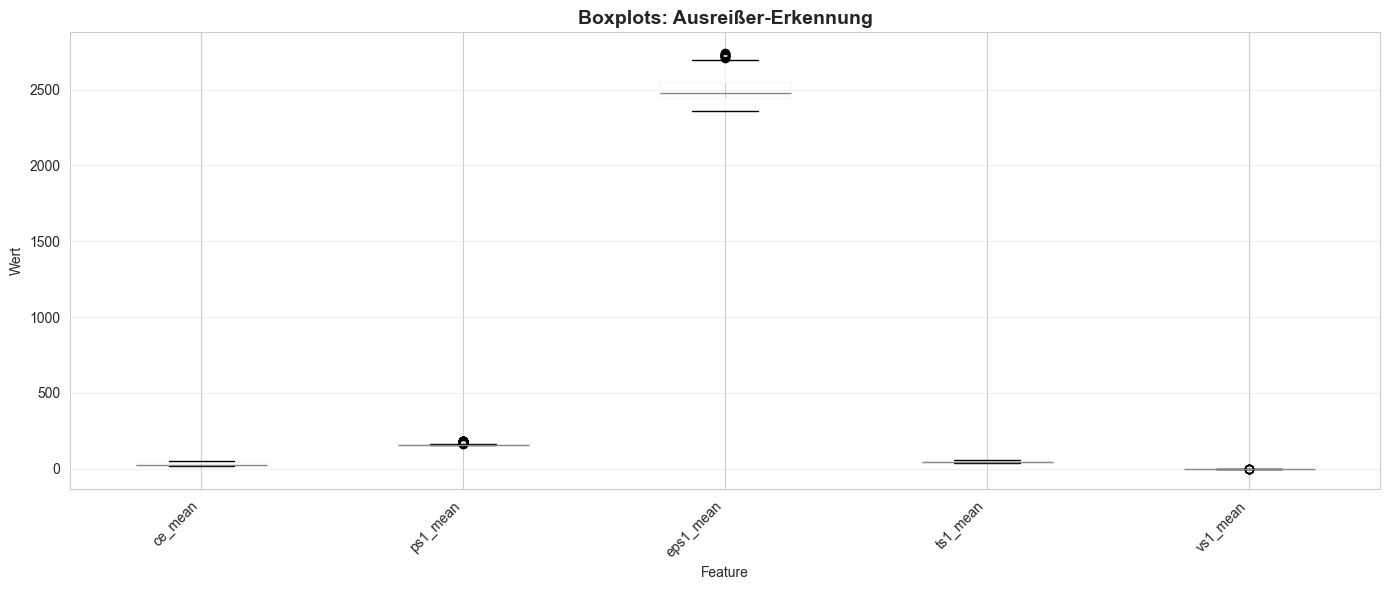

In [9]:
if 'df' in locals():
    # Boxplots für Ausreißer-Erkennung
    sample_features = ['ce_mean', 'ps1_mean', 'eps1_mean', 'ts1_mean', 'vs1_mean']
    available_features = [f for f in sample_features if f in df.columns]
    
    if len(available_features) > 0:
        plt.figure(figsize=(14, 6))
        df[available_features].boxplot(figsize=(14, 6))
        plt.title('Boxplots: Ausreißer-Erkennung', fontsize=14, fontweight='bold')
        plt.ylabel('Wert')
        plt.xlabel('Feature')
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
else:
    print("❌ Dataset nicht geladen.")

## 6. Korrelationsanalyse

Grundlegende Korrelationsanalyse um:
- **Redundante Features** zu identifizieren (hohe Korrelation)
- **Wichtige Zusammenhänge** zu verstehen
- **Features für theoretische Modellierung** auszuwählen

In [10]:
if 'df' in locals():
    # Korrelationsmatrix berechnen (nur Features, keine Targets)
    feature_cols = [col for col in df.columns if '_' in col and col not in targets.columns]
    corr_matrix = df[feature_cols].corr()
    
    print("=" * 70)
    print("KORRELATIONSMATRIX")
    print("=" * 70)
    print(f"Shape: {corr_matrix.shape}")
    print(f"Anzahl Korrelations-Paare: {(corr_matrix.shape[0] * (corr_matrix.shape[0] - 1)) // 2}")
    
    # Hohe Korrelationen finden (> 0.9)
    high_corr = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > 0.9:
                high_corr.append({
                    'Feature 1': corr_matrix.columns[i],
                    'Feature 2': corr_matrix.columns[j],
                    'Correlation': corr_matrix.iloc[i, j]
                })
    
    if len(high_corr) > 0:
        print(f"\n⚠ Hohe Korrelationen gefunden (|r| > 0.9): {len(high_corr)}")
        high_corr_df = pd.DataFrame(high_corr).sort_values('Correlation', key=abs, ascending=False)
        display(high_corr_df.head(20))
    else:
        print("\n✓ Keine extrem hohen Korrelationen gefunden (|r| > 0.9)")
else:
    print("❌ Dataset nicht geladen.")

KORRELATIONSMATRIX
Shape: (141, 141)
Anzahl Korrelations-Paare: 9870

⚠ Hohe Korrelationen gefunden (|r| > 0.9): 2046

⚠ Hohe Korrelationen gefunden (|r| > 0.9): 2046


,Feature 1,Feature 2,Correlation
1257,ps2_max,ps2_range,1.000000
1703,se_max,se_range,1.000000
1305,ps3_max,ps3_range,1.000000
808,fs1_max,fs1_range,1.000000
1536,ps6_mean,ps6_median,0.999999
1334,ps5_mean,ps5_median,0.999999
2007,ts4_mean,ts4_median,0.999997
839,fs2_mean,fs2_median,0.999997
1943,ts3_mean,ts3_median,0.999996
1622,ps6_median,ps6_q75,0.999996


### 💡 Interpretation der hohen Korrelationen

Die obige Tabelle zeigt **perfekte Korrelationen (r ≈ 1.0)** zwischen bestimmten Feature-Paaren. Das ist **mathematisch erwartbar** und kein Fehler:

**Perfekte Korrelationen (r = 1.0):**
- `max` ↔ `range`: Da `range = max - min` ist, und `min` konstant ist, sind diese Features perfekt korreliert
- Beispiel: `ps2_max` und `ps2_range` haben r = 1.0

**Sehr hohe Korrelationen (r > 0.999):**
- `mean` ↔ `median` ↔ `q25` ↔ `q75`: Bei symmetrischen Verteilungen (ohne Ausreißer) sind diese Lagemaße nahezu identisch
- Beispiel: `ps6_mean`, `ps6_median`, `ps6_q25`, `ps6_q75` korrelieren alle mit r > 0.999

**Konsequenzen für die Modellierung:**
- ✅ **Feature Selection notwendig:** Redundante Features können entfernt werden (z.B. `range` wenn `max` vorhanden)
- ✅ **Dimensionality Reduction:** PCA oder Lasso Regularization könnten helfen
- ⚠ **Multikollinearität:** Bei linearen Modellen (z.B. Lineare Regression) problematisch
- ✓ **Tree-based Modelle** (Random Forest, XGBoost) sind robust gegenüber hohen Korrelationen

**Fazit:** Die hohen Korrelationen sind **plausibel** und zeigen, dass die Sensoren in stabilen Bereichen messen. Für ML-Modelle sollten wir redundante Features entfernen.

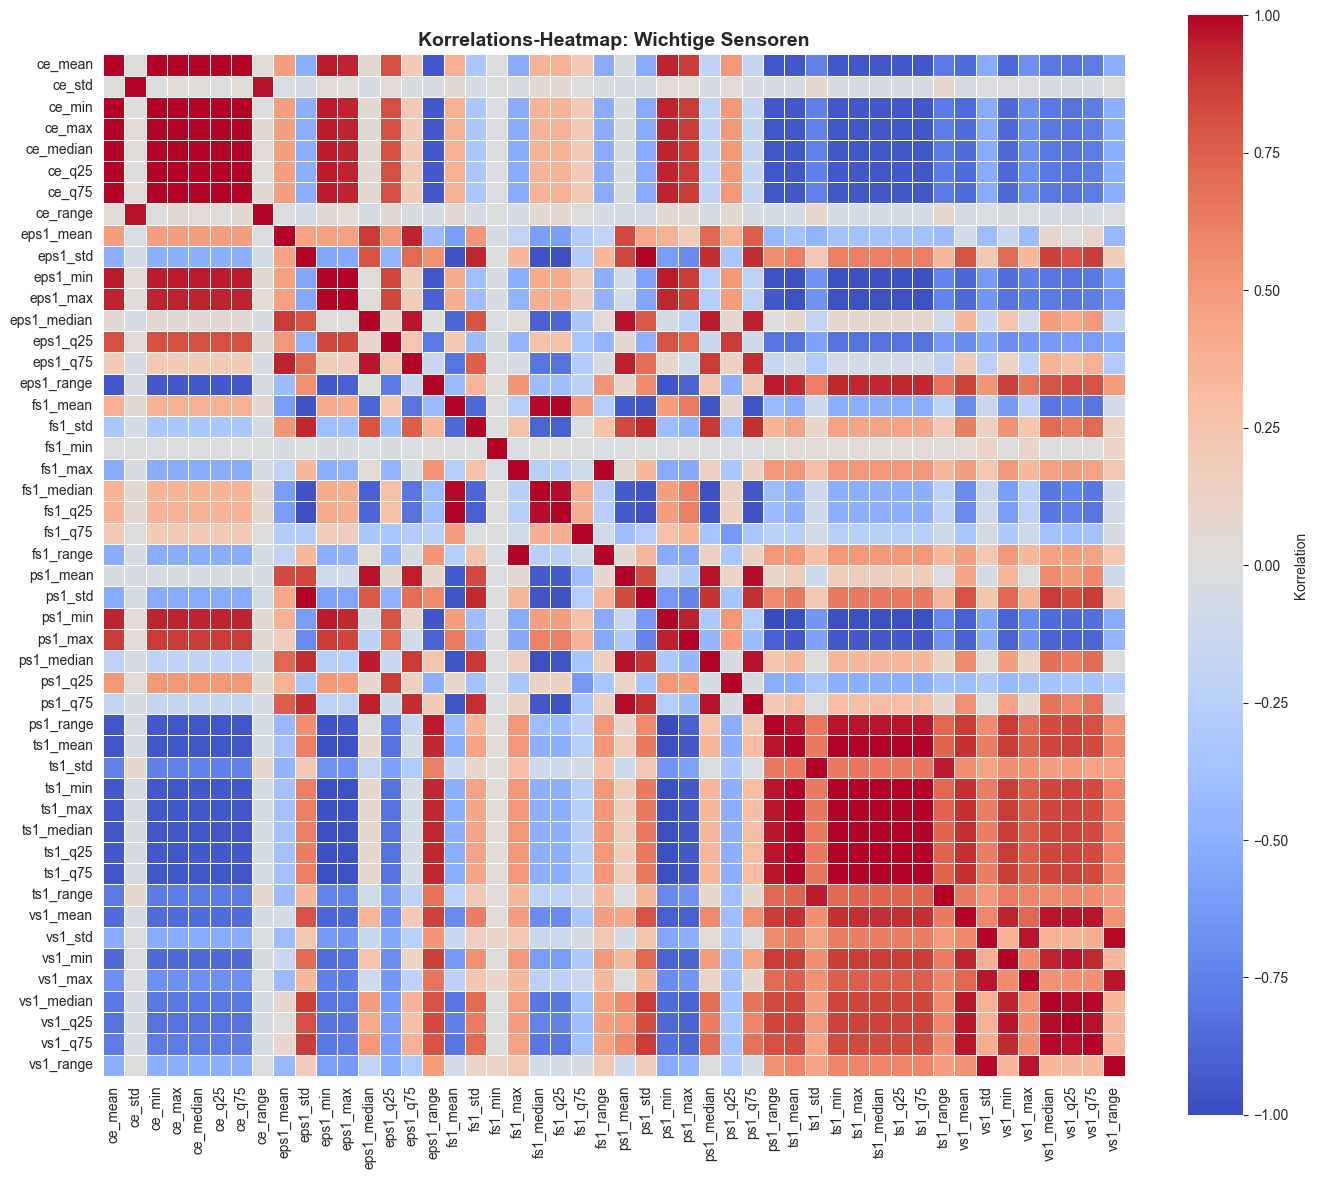

In [11]:
if 'df' in locals():
    # Heatmap der Korrelationsmatrix (Ausschnitt für bessere Lesbarkeit)
    # Wähle eine Teilmenge von Features für die Visualisierung
    important_sensors = ['ce', 'ps1', 'eps1', 'ts1', 'vs1', 'fs1']
    subset_cols = [col for col in feature_cols if any(col.startswith(f'{s}_') for s in important_sensors)]
    
    if len(subset_cols) > 0:
        corr_subset = df[subset_cols].corr()
        
        plt.figure(figsize=(14, 12))
        sns.heatmap(
            corr_subset, 
            annot=False,  # Keine Zahlen in Zellen (zu viele Features)
            cmap='coolwarm', 
            center=0,
            vmin=-1, 
            vmax=1,
            square=True,
            linewidths=0.5,
            cbar_kws={'label': 'Korrelation'}
        )
        plt.title('Korrelations-Heatmap: Wichtige Sensoren', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
else:
    print("❌ Dataset nicht geladen.")

In [12]:
if 'df' in locals():
    # Korrelation zwischen Features und Zielvariablen
    print("=" * 70)
    print("KORRELATION: FEATURES vs. ZIELVARIABLEN")
    print("=" * 70)
    
    for target_col in targets.columns:
        if target_col in df.columns:
            # Top 10 Features mit höchster Korrelation zur Zielvariable
            target_corr = df[feature_cols].corrwith(df[target_col]).abs().sort_values(ascending=False)
            
            print(f"\n{target_col.upper()}:")
            print("-" * 70)
            print(target_corr.head(10))
else:
    print("❌ Dataset nicht geladen.")

KORRELATION: FEATURES vs. ZIELVARIABLEN


In [ ]:
if 'df' in locals():
    # Visualisierung: Top Features pro Zielvariable
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    axes = axes.flatten()
    
    target_labels = {
        'cooler_condition': 'Kühlerzustand',
        'valve_condition': 'Ventilzustand',
        'pump_leakage': 'Pumpenleckage',
        'accumulator_pressure': 'Akkumulatordruck',
        'stable_flag': 'Systemstabilität'
    }
    
    for idx, target_col in enumerate(targets.columns):
        if target_col in df.columns:
            # Top 10 Features mit höchster Korrelation
            target_corr = df[feature_cols].corrwith(df[target_col]).abs().sort_values(ascending=False).head(10)
            
            target_corr.plot(kind='barh', ax=axes[idx], color='coral')
            axes[idx].set_title(f'Top 10 Features für: {target_labels.get(target_col, target_col)}', 
                                fontsize=11, fontweight='bold')
            axes[idx].set_xlabel('Absolute Korrelation')
            axes[idx].set_ylabel('Feature')
            axes[idx].grid(axis='x', alpha=0.3)
            axes[idx].invert_yaxis()  # Höchste Korrelation oben
    
    # Letzte Subplot leer lassen
    axes[-1].axis('off')
    
    plt.suptitle('Wichtigste Features pro Zielvariable (nach Korrelation)', 
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
else:
    print("❌ Dataset nicht geladen.")

## Zusammenfassung

### Analyseschritte

1. **Beschreibung** - 2.205 Messzyklen mit 5 Zielvariablen
2. **Aggregation** - Von 43.680 Spalten zu 136 Features
3. **Missings** - Keine fehlenden Werte im Dataset
4. **Plausibilität** - Min/Max, Mean/Median, Standardabweichung
5. **Korrelationen** - Zusammenhänge zwischen Features und Zielvariablen

### Output

Alle Ergebnisse wurden in `out/` gespeichert:
- `features_complete.csv` - Vollständiger Datensatz mit Features
- `feature_stats.csv` - Deskriptive Statistiken
- `correlation.csv` - Korrelationsmatrix